<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Спасибо за помощь, обязательно займусь изучением, интересно, но дольно таки сложно.
</div>

### <font color='orange'>Общее впечатление (ревью 2)</font>
* После исправлений проект улучшился и теперь он может быть зачтен.
* Для удобства все новые комментарии обозначены фразой "ревью 2".
* Удачи в дальнейшем обучении и следующих работах!

<h1>Проект для «Викишоп» с BERT</h1>


**Описание проекта**<br>
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.<br>
**Задача:**
Обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.
Построитиь модель со значением метрики качества F1 не меньше 0.75.


<h1>Алгоритм работы:</h1>


1.   Загрузка и подготовка данных
2.   Обучение модели
3.   Вывод



<h2>Загрузка и подготовка данных</h2>

In [213]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert

import pandas as pd
import seaborn as sns
import numpy as np
import re
import random
import math

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

In [214]:
df = pd.read_csv('toxic_comments.csv')

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [216]:
df.duplicated().sum()

0

In [217]:
df.isna().sum()

text     0
toxic    0
dtype: int64

In [218]:
df['toxic'].mean()

0.10167887648758234

<AxesSubplot:xlabel='toxic', ylabel='count'>

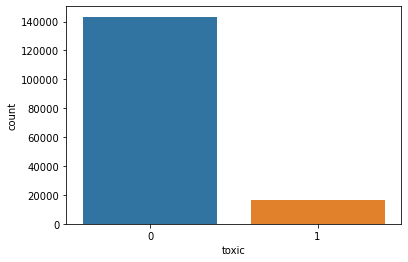

In [219]:
sns.countplot(x = 'toxic', data = df)

In [220]:
df.sample(5)

,text,toxic
124825,I note that TheOldJacobite has once again remo...,0
28958,which is confirmed by the viewpoint of other A...,0
40201,I'll correct what I said: The manis a former C...,1
16937,I request the removal of Saxifrage from being ...,0
131345,(which you need to leave until we resolve this),0


Дубликатов и Nan-значений нет. Дисбаланс ярковыражен, 10/90. Сбалансируем методом dawnsapled.(Важны "токсичные" комментарии, по этому так) <br>
Комментарии на английском языке.

Баланс достигнут.

Разобъем выборку на тестовую и обучающую 75/25

In [223]:
#X_train, X_test, y_train, y_test = train_test_split(df_balanced['text'],df_balanced['toxic'], stratify=df_balanced['toxic'])
train, test = train_test_split(df, test_size=.25, random_state=12345)

In [224]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

X_train = train['text']
y_train = train['toxic']
X_test = test['text']
y_test = test['toxic']
X_downsample, y_downsample = downsample(X_train, y_train, 0.1)
y_downsample.mean()
y_downsample.value_counts()

1    12138
0    10754
Name: toxic, dtype: int64

Модели BERT обычно предварительно обучены. Они доступны в TensorFlow Hub . TensorFlow Hub содержит все загружаемые предварительно обученные модели машинного обучения.

Мы загрузим две модели, одну для предварительной обработки, а другую для кодирования. 

In [226]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

<h2>Обучение модели</h2>

Инициализация слоев BERT

In [227]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

Инициализация слоев нейронной сети

In [228]:
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

Инициализация модели

In [229]:
model = tf.keras.Model(inputs=[text_input], outputs = [l])

Краткое описание модели

In [230]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_14 (KerasLayer)    {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

Устанавливаем параметры и метрики для нашей модели.

In [231]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
 loss='binary_crossentropy',
 metrics=METRICS)

Начинаем обучение.

In [232]:
model.fit(X_downsample, y_downsample, epochs=3)

Epoch 1/3
716/716 [==============================] - 4078s 6s/step - loss: 0.5323 - accuracy: 0.7382 - precision: 0.7447 - recall: 0.7702
Epoch 2/3
716/716 [==============================] - 4039s 6s/step - loss: 0.4244 - accuracy: 0.8124 - precision: 0.8233 - recall: 0.8228
Epoch 3/3
716/716 [==============================] - 3666s 5s/step - loss: 0.3933 - accuracy: 0.8285 - precision: 0.8388 - recall: 0.8375


Всего три эпохи, каждая по 3+ часа...можно было достичь лучшего результата, нет времени)

Предсказания. 

In [233]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

Еще час.

Переведем массив с предсказаниями в одномерный

In [234]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, ..., 0, 0, 0])

Вычисляем F1

In [235]:
print(f1_score(y_predicted, y_test))
print(accuracy_score(y_predicted, y_test))
print(recall_score(y_predicted, y_test)) 
print(precision_score(y_predicted, y_test))

0.4985321226189664
0.8158824856491114
0.3457386363636364
0.8933202838267678


Процедура "очистки" текста.

In [238]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [239]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

"Чистим" текст.

In [240]:
reviews = []
sentences = list(df['text'])
for sen in sentences:
    reviews.append(preprocess_text(sen))

In [241]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [242]:
def tokenize_reviews(text_reviews):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_reviews))

In [243]:
tokenized_reviews = [tokenize_reviews(review) for review in reviews]

In [244]:
y = df['toxic']

In [245]:
reviews_with_len = [[review, y[i], len(review)]
                 for i, review in enumerate(tokenized_reviews)]

In [246]:
random.shuffle(reviews_with_len)

In [247]:
sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in reviews_with_len]

In [248]:
processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels, output_types=(tf.int32, tf.int32))

In [249]:
BATCH_SIZE = 32
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [250]:
TOTAL_BATCHES = math.ceil(len(sorted_reviews_labels) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 10
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)

In [251]:
class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [252]:
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2

DROPOUT_RATE = 0.2

NB_EPOCHS = 5
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
]

In [253]:
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

In [254]:
if OUTPUT_CLASSES == 2:
    text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=[METRICS])
else:
    text_model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["sparse_categorical_accuracy"])

In [255]:
text_model.fit(train_data, epochs=NB_EPOCHS)

Epoch 1/5
4489/4489 [==============================] - 1609s 358ms/step - loss: 0.1194 - accuracy: 0.9567 - precision: 0.8510 - recall: 0.6953
Epoch 2/5
4489/4489 [==============================] - 1606s 357ms/step - loss: 0.0712 - accuracy: 0.9730 - precision: 0.8913 - recall: 0.8359
Epoch 3/5
4489/4489 [==============================] - 1606s 357ms/step - loss: 0.0356 - accuracy: 0.9875 - precision: 0.9422 - recall: 0.9343
Epoch 4/5
4489/4489 [==============================] - 1605s 357ms/step - loss: 0.0195 - accuracy: 0.9938 - precision: 0.9695 - recall: 0.9691
Epoch 5/5
4489/4489 [==============================] - 1607s 358ms/step - loss: 0.0136 - accuracy: 0.9951 - precision: 0.9770 - recall: 0.9749


In [256]:
results = text_model.evaluate(test_data)
print(results)

498/498 [==============================] - 71s 142ms/step - loss: 0.2331 - accuracy: 0.9576 - precision: 0.8287 - recall: 0.7444
[0.23314973711967468, 0.9575803279876709, 0.8287255764007568, 0.7443973422050476]


In [257]:
f1_score = 2*(results[2]*results[3]/(results[2]+results[3]))
f1_score

0.7843012255352609

<h2>Вывод:</h2>
Задача выполнена, результат: f1 - 0.857